In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn tensorflow opencv-python


Note: you may need to restart the kernel to use updated packages.


Epoch 1/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8801 - loss: 0.2775 - val_accuracy: 0.8993 - val_loss: 0.2260
Epoch 2/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9196 - loss: 0.1853 - val_accuracy: 0.9268 - val_loss: 0.1659
Epoch 3/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9351 - loss: 0.1489 - val_accuracy: 0.9435 - val_loss: 0.1306
Epoch 4/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9450 - loss: 0.1307 - val_accuracy: 0.9483 - val_loss: 0.1194
Epoch 5/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9472 - loss: 0.1255 - val_accuracy: 0.9517 - val_loss: 0.1129
Epoch 6/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9479 - loss: 0.1204 - val_accuracy: 0.9523 - val_loss: 0.1102
Epoch 7/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9548 - loss: 0.1093 - val_accuracy: 0.9544 - val_loss: 0.1059
Epoch 8/10
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9533 - loss: 0.1078 - 

C:\Users\sagni\AppData\Local\Temp\ipykernel_992\3563869543.py:97: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
C:\Users\sagni\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


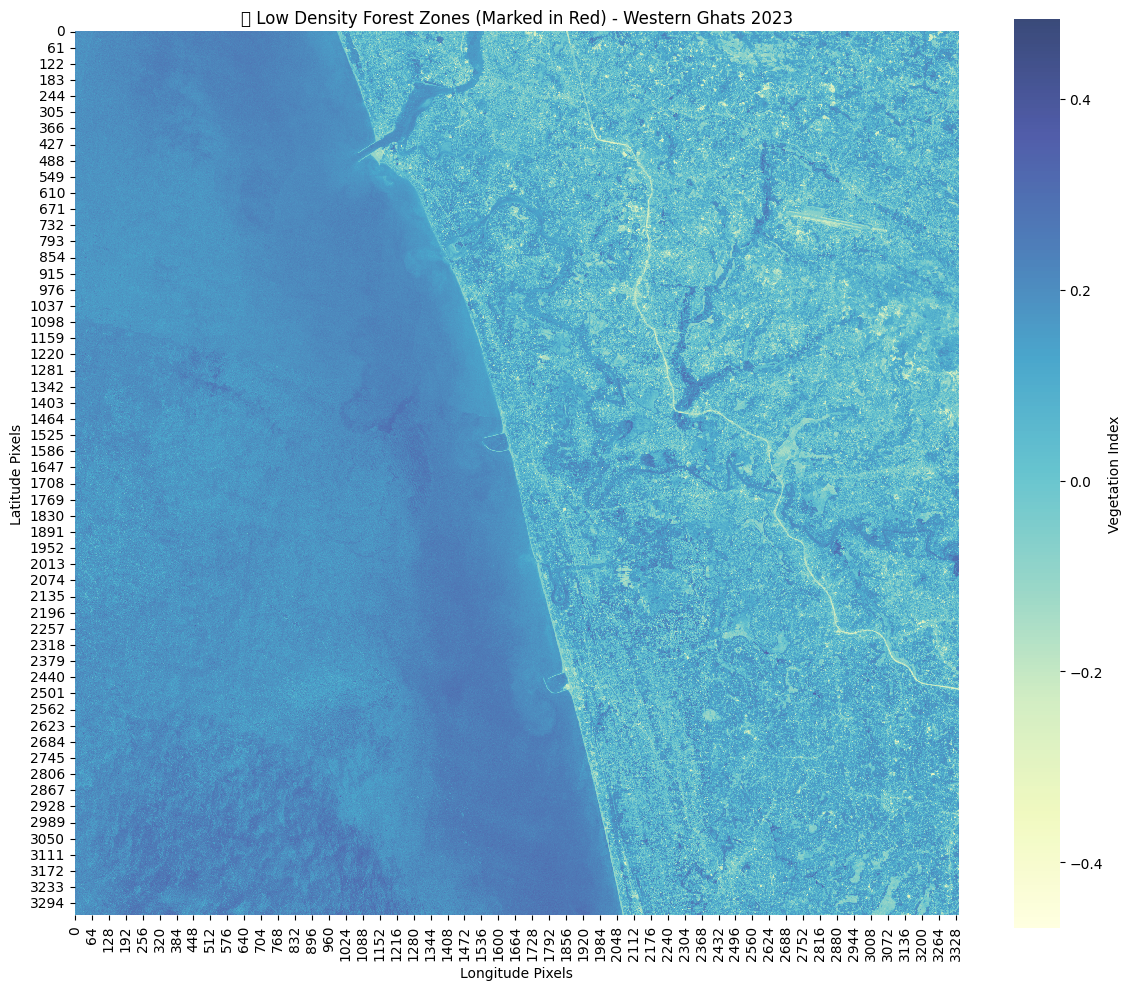

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# === Load CSV ===
csv_path = "C:/Users/sagni/Downloads/Deforestation Detection/Western_Ghats_Forest_2023.csv"
df = pd.read_csv(csv_path).dropna()

# === Generate NDVI-like vegetation index (simplified) ===
df['veg_index'] = (df['green'] - df['red']) / (df['green'] + df['red'] + 1e-5)

# === Threshold for low-density forest (adjust as needed) ===
df['label'] = df['veg_index'].apply(lambda x: 1 if x < 0.2 else 0)  # 1 = low-density

# === Reshape for patching ===
coords = df[['latitude', 'longitude']].values
values = df['veg_index'].values
labels = df['label'].values

# === Create image grid ===
lats = np.sort(df['latitude'].unique())[::-1]
lons = np.sort(df['longitude'].unique())

heatmap = df.pivot_table(index='latitude', columns='longitude', values='veg_index').sort_index(ascending=False)
label_map = df.pivot_table(index='latitude', columns='longitude', values='label').sort_index(ascending=False)

image = heatmap.fillna(0).values
mask = label_map.fillna(0).values.astype(np.uint8)

# === Extract patches ===
def extract_patches(img, labels, patch_size=16):
    X, y = [], []
    for i in range(0, img.shape[0] - patch_size, patch_size):
        for j in range(0, img.shape[1] - patch_size, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            label = labels[i + patch_size//2, j + patch_size//2]
            X.append(patch)
            y.append(label)
    return np.array(X)[..., np.newaxis], np.array(y)

X, y = extract_patches(image, mask, patch_size=16)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Multiscale CNN Model ===
def build_multiscale_cnn(input_shape):
    inp = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inp)
    x1 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(16, (5,5), activation='relu', padding='same')(inp)
    x2 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(16, (7,7), activation='relu', padding='same')(inp)
    x3 = layers.MaxPooling2D()(x3)

    x = layers.concatenate([x1, x2, x3])
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=inp, outputs=out)

model = build_multiscale_cnn(X_train[0].shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# === Predict Entire Image ===
pred_mask = np.zeros_like(mask, dtype=float)
patch_size = 16
for i in range(0, image.shape[0] - patch_size, patch_size):
    for j in range(0, image.shape[1] - patch_size, patch_size):
        patch = image[i:i+patch_size, j:j+patch_size]
        if patch.shape == (16,16):
            input_patch = patch[np.newaxis, ..., np.newaxis]
            pred = model.predict(input_patch, verbose=0)[0][0]
            pred_mask[i + patch_size//2, j + patch_size//2] = pred

# === Mark Low Density Forest Zones ===
threshold = 0.5
low_density = (pred_mask > threshold).astype(int)

# === Visualize on Heatmap ===
plt.figure(figsize=(12,10))
sns.heatmap(image, cmap='YlGnBu', cbar_kws={'label': 'Vegetation Index'}, alpha=0.8)
plt.imshow(low_density, cmap='Reds', alpha=0.4)
plt.title("🔥 Low Density Forest Zones (Marked in Red) - Western Ghats 2023")
plt.xlabel("Longitude Pixels")
plt.ylabel("Latitude Pixels")
plt.tight_layout()
plt.show()
